#Tutorial for [Caffe](https://github.com/BVLC/caffe)
### Using trained models
1. Use existing model to get feature from different layers
### Train a new model
1. Fine-tune model

##Example 1.Using Pre-trained model to predict objects
1. In this example, VGG16 is chosen for the demonstration. Various pre-trained models can be downloaded from [Model_Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). The details for how to download the model can be seen from the Model Zoo webpage.

2. [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) image database is used for demenstration.

In [41]:
import caffe
import matplotlib.pylab as plt
from glob import glob
import numpy as np
## Load Pre-trained Model
model_dir = "/Users/ruoxu/opt/caffe/models/bvlc_reference_caffenet/deploy.prototxt"
weights_dir = "/Users/ruoxu/opt/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
%time net = caffe.Classifier(model_dir,weights_dir)
                             #,mean=np.load("/Users/ruoxu/opt/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy"),channel_swap=(2,1,0),raw_scale=255,image_dims=(256, 256))
%matplotlib inline

CPU times: user 794 ms, sys: 430 ms, total: 1.22 s
Wall time: 1.23 s


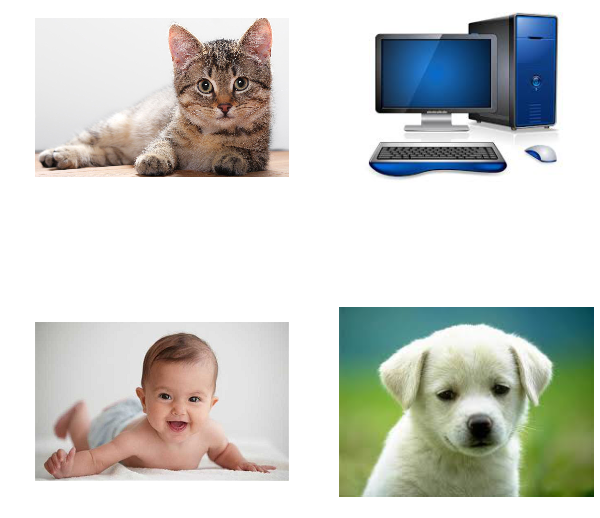

In [45]:
dog_im = plt.imread("../dog.jpeg")
cat_im = plt.imread("../cat.jpg")
comp_im = plt.imread("../computer.jpeg")
baby_im = plt.imread("../baby.jpg")
ims = [dog_im, cat_im, comp_im, baby_im]
i = 0
plt.figure(figsize=(10,10))
for im in ims:
    plt.subplot(2,2,i)
    plt.axis('off')
    plt.imshow(im)
    i+=1

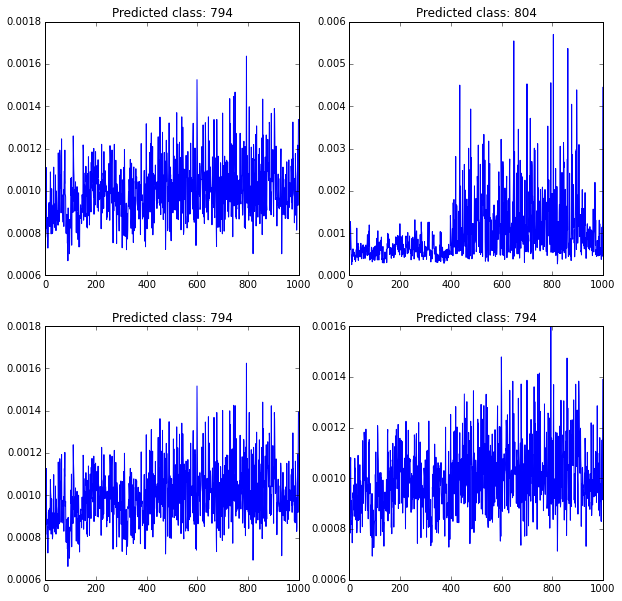

In [46]:
from skimage.transform import resize
ims_resized = [resize(im,(227,227)) for im in ims]
pred_class = net.predict(ims_resized)
i = 0
plt.figure(figsize=(10,10))
for pred in pred_class:
    plt.subplot(2,2,i)
    plt.plot(xrange(pred.shape[0]),pred)
    plt.title("Predicted class: " + str(np.argmax(pred)))
    i+=1

### Use pre-trained model to get features
1. We can look into net.blobs to see the layer name and access feature by specifying the name.
2. After feeding image into the model, features can be taken by specifying the layer name.

In [66]:
score = net.predict([resize(dog_im,(227,227))])
print 'Layer Names:'
print
for blob in net.blobs:
    print blob

Layer Names:

data
conv1
pool1
norm1
conv2
pool2
norm2
conv3
conv4
conv5
pool5
fc6
fc7
fc8
prob


In [67]:
for blob in net.blobs:
    print 'Layer: ' + blob + '| Feature shape: ' + str(net.blobs[blob].data.shape)

Layer: data| Feature shape: (10, 3, 227, 227)
Layer: conv1| Feature shape: (10, 96, 55, 55)
Layer: pool1| Feature shape: (10, 96, 27, 27)
Layer: norm1| Feature shape: (10, 96, 27, 27)
Layer: conv2| Feature shape: (10, 256, 27, 27)
Layer: pool2| Feature shape: (10, 256, 13, 13)
Layer: norm2| Feature shape: (10, 256, 13, 13)
Layer: conv3| Feature shape: (10, 384, 13, 13)
Layer: conv4| Feature shape: (10, 384, 13, 13)
Layer: conv5| Feature shape: (10, 256, 13, 13)
Layer: pool5| Feature shape: (10, 256, 6, 6)
Layer: fc6| Feature shape: (10, 4096)
Layer: fc7| Feature shape: (10, 4096)
Layer: fc8| Feature shape: (10, 1000)
Layer: prob| Feature shape: (10, 1000)


###Fine tune model
1. Download the [wood_knots](http://www.ee.oulu.fi/~olli/Projects/Lumber.Grading.html) dataset.
2. Load image paths and image labels. 
3. Write image directory and label into a text file in the format of “[path/to/image.jpeg] [label]”. 
4. Use $CAFFE_ROOT/tools/convert_imageset.cpp to convert the data for feeding into the network.
5. edit solver.prototxt, train_val.prototxt and deploy.prototxt
6. Train the model and get the results

In [1]:
import numpy as np
import matplotlib.pylab as plt
#import h5py
#import tempfile
import caffe
import os
%matplotlib inline

In [3]:
from glob import glob

labels = {}
with open("../data/wood_knots/names.txt","r") as f:
    for l in f.readlines():
        name, label = l.strip().split(' ')
        labels[name] = label

### Prepare data for fine-tuning

In [4]:
X = []
Y = []
for l in labels.keys():
    X.append(l)
    Y.append(labels[l])
from collections import Counter
print Counter(Y)
    
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

print "X[:10] ", X[:10]
print "Y[:10] ", Y[:10]

Counter({'sound_knot': 179, 'dry_knot': 69, 'edge_knot': 65, 'leaf_knot': 47, 'horn_knot': 35, 'encased_knot': 29, 'decayed_knot': 14})
X[:10]  ['knot0119.ppm', 'knot0251.ppm', 'knot0332.ppm', 'knot0105.ppm', 'knot0345.ppm', 'knot0037.ppm', 'knot0166.ppm', 'knot0141.ppm', 'knot0350.ppm', 'knot0337.ppm']
Y[:10]  [6 4 6 1 6 1 2 5 6 6]


In [8]:
from sklearn.cross_validation import train_test_split
X_train, X_tmp, Y_train, Y_tmp = train_test_split(X,Y,test_size = 0.4)
X_val, X_test, Y_val, Y_test = train_test_split(X_tmp, Y_tmp, test_size = 0.5)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)
print len(X_train), len(Y_train)
print len(X_test), len(Y_test)
print len(X_val), len(Y_val)

262 262
88 88
88 88


In [9]:
save_dir = "/Users/ruoxu/workspace/deeplearning-exploration/data/model"
train_file_name = os.path.join(save_dir, "train.txt")
test_file_name = os.path.join(save_dir,"test.txt")
val_file_name = os.path.join(save_dir, "val.txt")
with open(train_file_name,"w") as f:
    for item in zip(X_train,Y_train):
        f.write("%s\n" % (item[0] +' '+ str(item[1])))
with open(test_file_name,"w") as f:
    for item in zip(X_test,Y_test):
        f.write("%s\n" % (item[0] +' '+ str(item[1])))
with open(val_file_name,"w") as f:
    for item in zip(X_val,Y_val):
        f.write("%s\n" % (item[0] +' '+ str(item[1])))

In [20]:
!../data/model/create_data.sh

Creating train lmdb...
I0426 10:01:24.642920 1974080256 convert_imageset.cpp:79] Shuffling data
I0426 10:01:24.649600 1974080256 convert_imageset.cpp:82] A total of 262 images.
I0426 10:01:24.650048 1974080256 db.cpp:34] Opened lmdb /Users/ruoxu/workspace/deeplearning-exploration/data/model/knots_train_lmdb
E0426 10:01:25.139701 1974080256 convert_imageset.cpp:149] Processed 262 files.
Creating val lmdb...
I0426 10:01:25.179564 1974080256 convert_imageset.cpp:79] Shuffling data
I0426 10:01:25.191026 1974080256 convert_imageset.cpp:82] A total of 88 images.
I0426 10:01:25.191581 1974080256 db.cpp:34] Opened lmdb /Users/ruoxu/workspace/deeplearning-exploration/data/model/knots_val_lmdb
E0426 10:01:25.345474 1974080256 convert_imageset.cpp:149] Processed 88 files.
Done.


###Load the pre-trained model and fine-tune it
1. Copy the deploy.prototxt, train_val.prototxt, solver.prototxt in $CAFFE_ROOT/models/bvlc_reference_caffenet
and 
2. In the deploy.prototxt file Rename the layer "fc8" to "fc8_wood". Set num_output: 7
3. Fine-tune the model


In [25]:
! /Users/ruoxu/opt/caffe/build/tools/caffe train -solver ../data/finetuned_wood_knots/solver.prototxt -weights ../data/finetuned_wood_knots/bvlc_reference_caffenet.caffemodel

I0426 10:13:36.472812 1974080256 caffe.cpp:117] Use CPU.
I0426 10:13:36.474073 1974080256 caffe.cpp:121] Starting Optimization
I0426 10:13:36.474092 1974080256 solver.cpp:32] Initializing solver from parameters: 
test_iter: 5
test_interval: 5
base_lr: 0.0001
display: 20
max_iter: 200
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0001
stepsize: 5
snapshot: 10000
snapshot_prefix: "/Users/ruoxu/workspace/deeplearning-exploration/data/model/caffenet_train"
solver_mode: CPU
net: "/Users/ruoxu/workspace/deeplearning-exploration/data/finetuned_wood_knots/train_val.prototxt"
I0426 10:13:36.474182 1974080256 solver.cpp:70] Creating training net from net file: /Users/ruoxu/workspace/deeplearning-exploration/data/finetuned_wood_knots/train_val.prototxt
I0426 10:13:36.474759 1974080256 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0426 10:13:36.474786 1974080256 net.cpp:257] The NetState phase (0) differed from the phase (1) specifi

Comment 1: I tried to save file using HDF5 instead of using LMDB. However, the transform_param in HDF5Data layer seems not working.

Comment 2: the tuning example is not good enough, as the loss keeps oscillating instead of decreasing. I'll come with better examples.

### Using the trained model to test